In [1]:
import os
from keras.datasets import mnist
import random 
from matplotlib import pyplot as plt
import numpy as np
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Softmax, Multiply
import tensorflow as tf

In [2]:
#load the data from the mnist dataset
(train_img, train_label), (test_img, test_label) = mnist.load_data()

In [3]:
# Combine the features and labels for shuffling
train_data = list(zip(train_img, train_label))

# Shuffle the training data
np.random.shuffle(train_data)

# Unzip the shuffled data back into separate arrays for features and labels
train_img, train_label = zip(*train_data)

# Convert back to numpy arrays if needed
train_img = np.array(train_img)
train_label = np.array(train_label)

In [4]:
#split training data into train and validation sets
val_split = 1/6
val_size = int(val_split * len(train_img))

val_img = train_img[:val_size]
val_label = train_label[:val_size]

train_img = train_img[val_size:]
train_label = train_label[val_size:]

In [5]:
#normalize pixel values to range [0, 1]
train_img = train_img / 255.0
test_img = test_img / 255.0
val_img = val_img / 255.0

In [6]:
#visualize size of data sets
print(train_img.shape)
print(test_img.shape)
print(val_img.shape)
print(train_label.shape)
print(test_label.shape)
print(val_label.shape)

(50000, 28, 28)
(10000, 28, 28)
(10000, 28, 28)
(50000,)
(10000,)
(10000,)


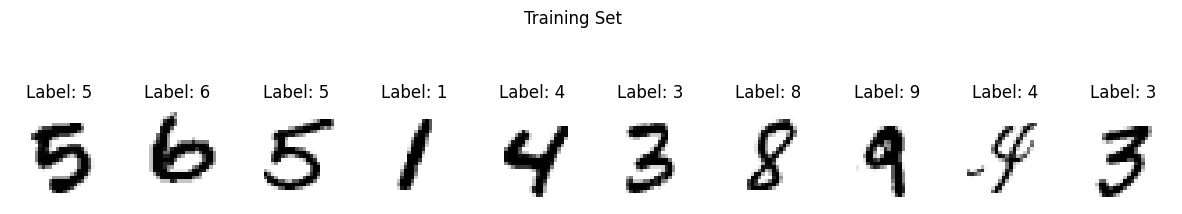

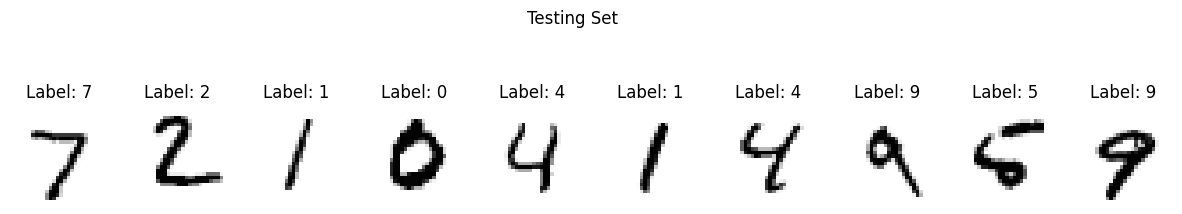

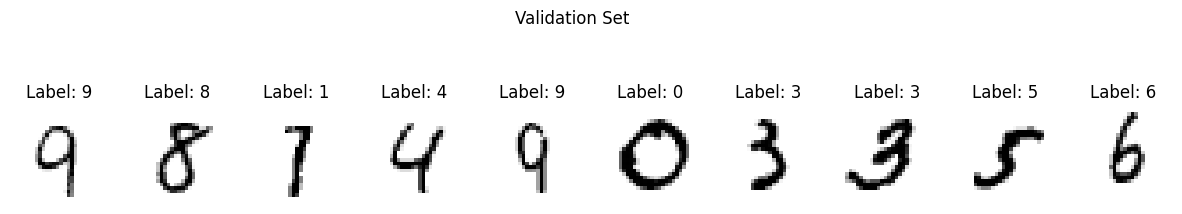

In [7]:
#visualize 10 images and their labels from each set
def plot_images(images, labels, title):
    plt.figure(figsize=(15, 3))
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Plot images and labels from the training set
plot_images(train_img[:10], train_label[:10], "Training Set")

# Plot images and labels from the testing set
plot_images(test_img[:10], test_label[:10], "Testing Set")

# Plot images and labels from the testing set
plot_images(val_img[:10], val_label[:10], "Validation Set")

In [8]:
#one-hot ecode labels
train_label=to_categorical(train_label)
test_label=to_categorical(test_label)
val_label=to_categorical(val_label)

In [9]:
def create_baseline_model():
    return Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(10, activation='softmax'),
    ])

In [10]:
def create_tanh_activation_model():
    return Sequential([
        Conv2D(32, (3, 3), activation='tanh', input_shape=(28, 28, 1)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='tanh'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='tanh'),
        Dropout(0.2),
        Dense(10, activation='softmax'),
    ])

In [11]:
# Define the custom attention layer
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.filters = input_shape[3]
        self.W = self.add_weight(name='attention_W', shape=(1, 1, self.filters, self.filters), initializer="glorot_uniform", trainable=True)
        self.b = self.add_weight(name='attention_b', shape=(self.filters,), initializer="zeros", trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        attention_weights = tf.nn.tanh(tf.nn.conv2d(inputs, self.W, strides=[1, 1, 1, 1], padding="SAME") + self.b)
        attention_weights = Softmax(axis=-1)(attention_weights)
        attended_inputs = Multiply()([inputs, attention_weights])
        return attended_inputs

def create_attention_mechanism_model():
    return Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        AttentionLayer(),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(10, activation='softmax'),
    ])

In [12]:
model_creation_functions = {
    "baseline_model": create_baseline_model,
    "tanh_activation_model": create_tanh_activation_model,
    "attention_mechanism_model": create_attention_mechanism_model
}

In [13]:
for model_name, create_model_func in model_creation_functions.items():
    model = create_model_func()  # Create a new instance of the model
    print(f"Model: {model_name}")
    model.summary()
    print("\n")

Model: baseline_model
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense (Dense)               (None

In [14]:
def train_and_save_model(create_model_func, train_img, train_label, test_img, test_label, model_name, num_epochs=9, batch_size=256):
    model = create_model_func()  # Create a new instance of the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
    history = model.fit(train_img, train_label, epochs=num_epochs, batch_size=batch_size, validation_data=(test_img, test_label))
    model.save(f'{model_name}.h5')
    return history

# Train and save all models
histories = {}
for model_name, create_model_func in model_creation_functions.items():
    for i in range(1, 4):
        history = train_and_save_model(create_model_func, train_img, train_label, test_img, test_label, f'{model_name}_{i}')
        histories[f'{model_name}_{i}'] = history
        print(f'{model_name.capitalize()} {i} trained and saved.')

Epoch 1/9
196/196 [==============================] - 16s 79ms/step - loss: 0.3608 - acc: 0.8927 - val_loss: 0.0816 - val_acc: 0.9751
Epoch 2/9
196/196 [==============================] - 16s 79ms/step - loss: 0.0910 - acc: 0.9724 - val_loss: 0.0527 - val_acc: 0.9823
Epoch 3/9
196/196 [==============================] - 15s 79ms/step - loss: 0.0614 - acc: 0.9814 - val_loss: 0.0430 - val_acc: 0.9869
Epoch 4/9
196/196 [==============================] - 15s 79ms/step - loss: 0.0490 - acc: 0.9852 - val_loss: 0.0333 - val_acc: 0.9894
Epoch 5/9
196/196 [==============================] - 16s 81ms/step - loss: 0.0398 - acc: 0.9879 - val_loss: 0.0332 - val_acc: 0.9898
Epoch 6/9
196/196 [==============================] - 15s 79ms/step - loss: 0.0336 - acc: 0.9898 - val_loss: 0.0307 - val_acc: 0.9896
Epoch 7/9
196/196 [==============================] - 16s 79ms/step - loss: 0.0281 - acc: 0.9916 - val_loss: 0.0279 - val_acc: 0.9907
Epoch 8/9
196/196 [==============================] - 16s 79ms/step - 

Epoch 7/9
196/196 [==============================] - 17s 86ms/step - loss: 0.0483 - acc: 0.9847 - val_loss: 0.0421 - val_acc: 0.9863
Epoch 8/9
196/196 [==============================] - 17s 86ms/step - loss: 0.0432 - acc: 0.9869 - val_loss: 0.0402 - val_acc: 0.9859
Epoch 9/9
196/196 [==============================] - 17s 85ms/step - loss: 0.0386 - acc: 0.9881 - val_loss: 0.0415 - val_acc: 0.9859
Attention_mechanism_model 1 trained and saved.
Epoch 1/9
196/196 [==============================] - 18s 87ms/step - loss: 0.7183 - acc: 0.7910 - val_loss: 0.1384 - val_acc: 0.9579
Epoch 2/9
196/196 [==============================] - 17s 85ms/step - loss: 0.1409 - acc: 0.9579 - val_loss: 0.0888 - val_acc: 0.9741
Epoch 3/9
196/196 [==============================] - 16s 84ms/step - loss: 0.1000 - acc: 0.9694 - val_loss: 0.0785 - val_acc: 0.9755
Epoch 4/9
196/196 [==============================] - 16s 84ms/step - loss: 0.0807 - acc: 0.9749 - val_loss: 0.0574 - val_acc: 0.9806
Epoch 5/9
196/196 [===

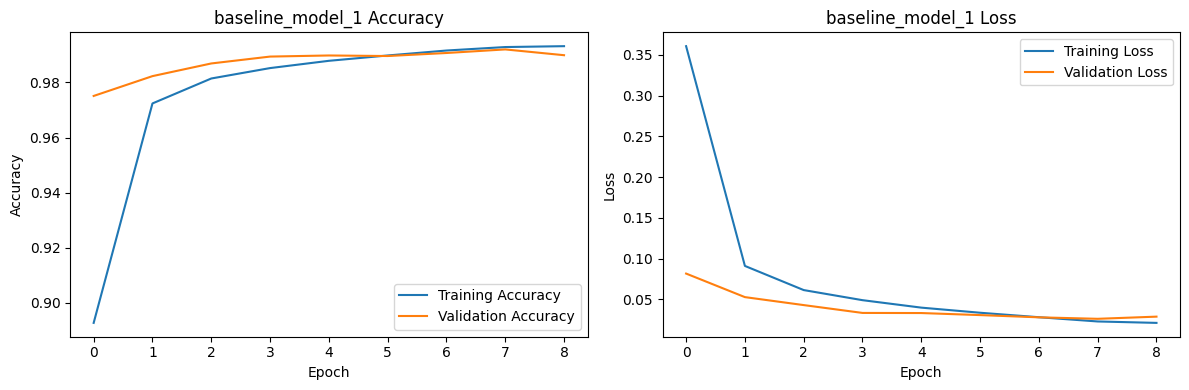

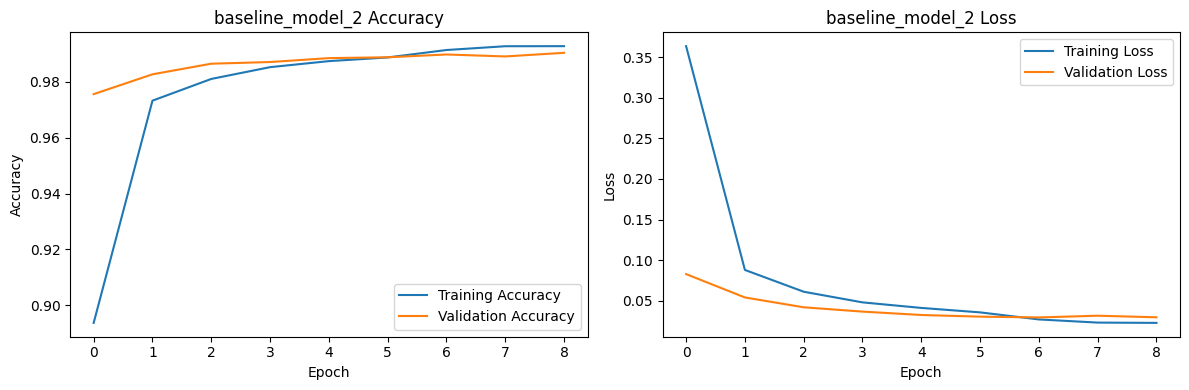

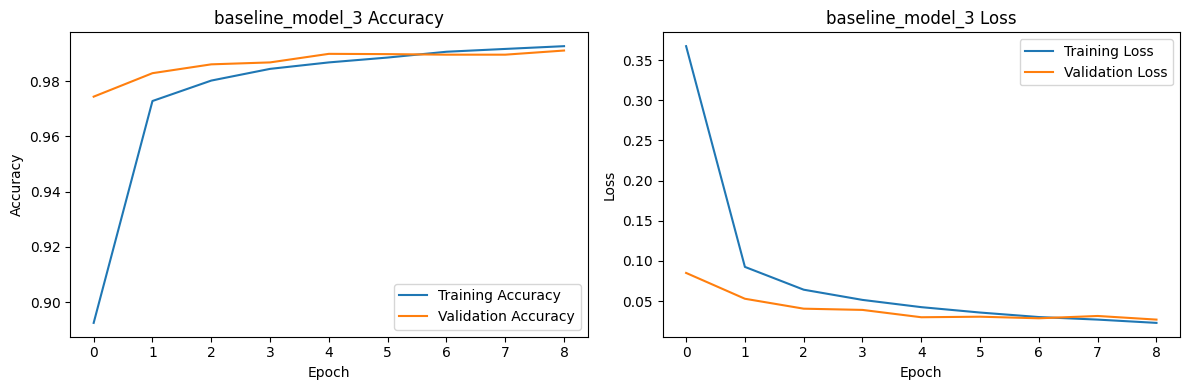

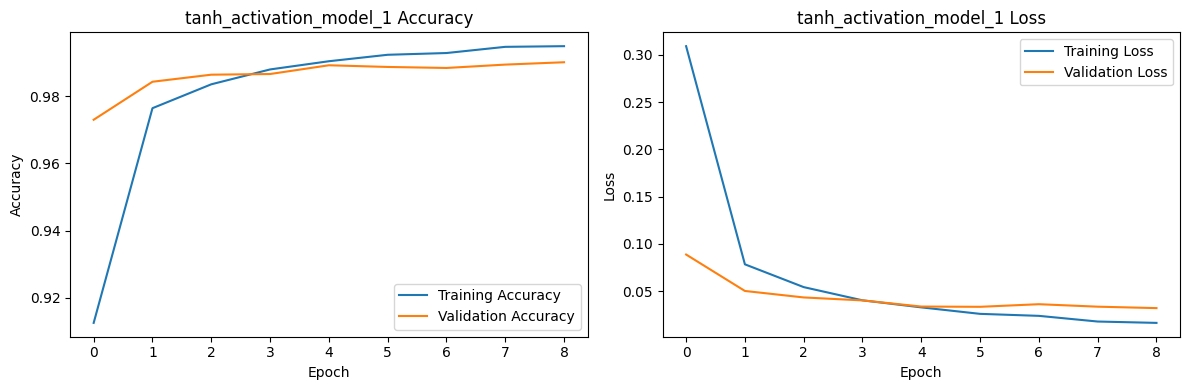

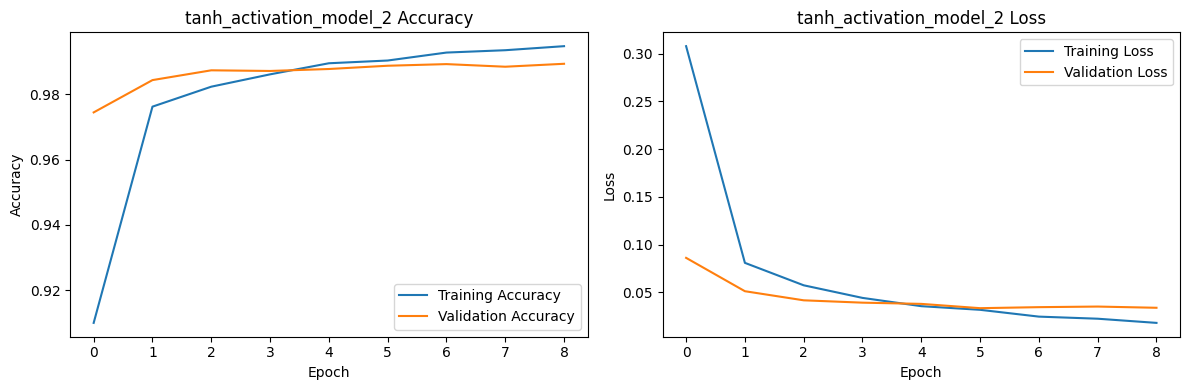

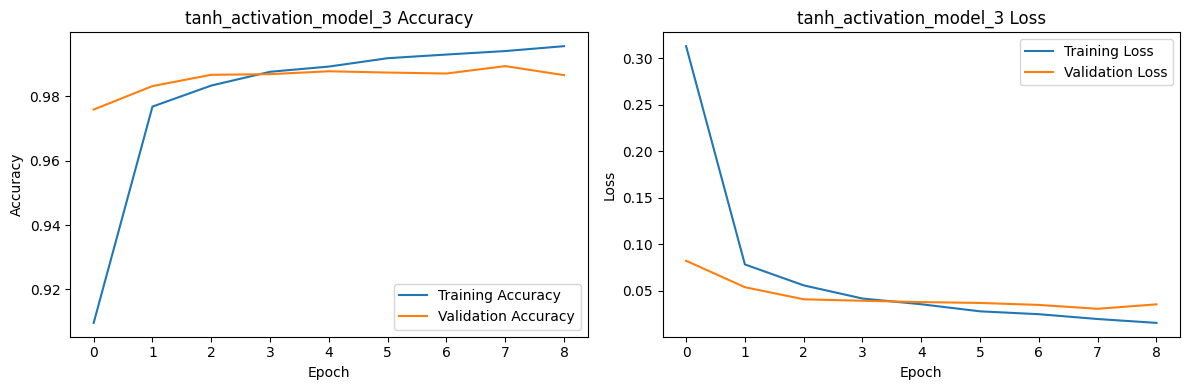

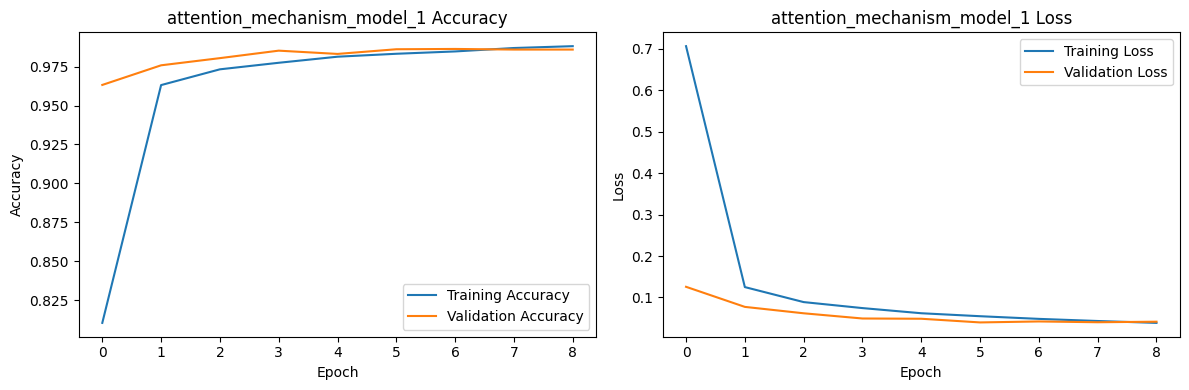

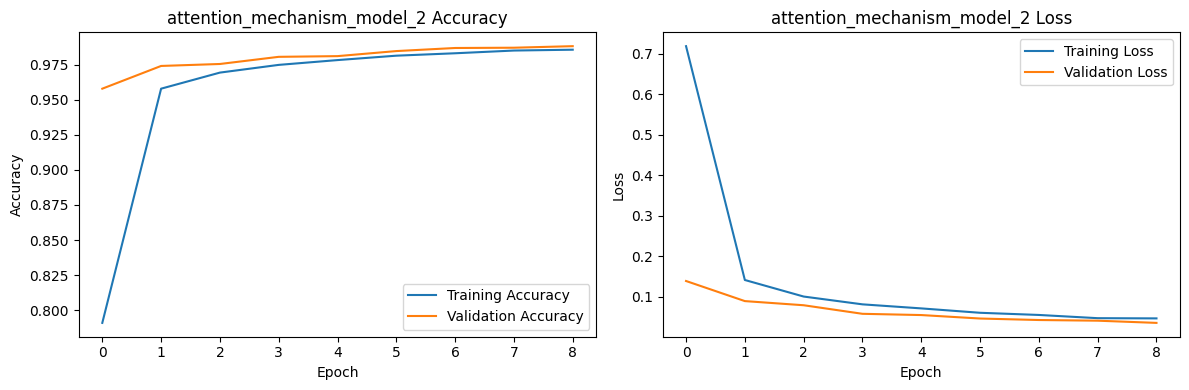

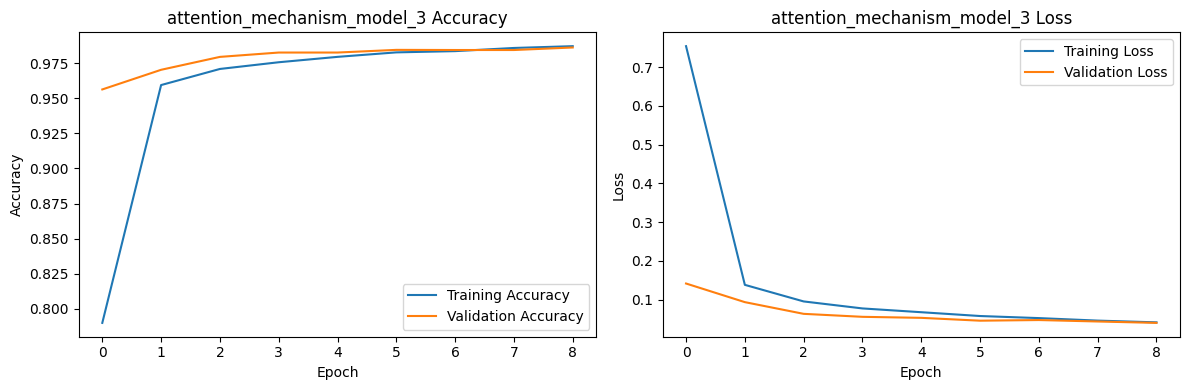

In [15]:
# Display all histories with pyplot
for model_name, history in histories.items():
    plt.figure(figsize=(12, 4))

    # Plot training and validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['acc'], label='Training Accuracy')
    plt.plot(history.history['val_acc'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [16]:
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [17]:
loaded_models = {}
for model_name in model_creation_functions.keys():
    for i in range(1, 4):
        model_path = f'{model_name}_{i}.h5'
        if model_name == "attention_mechanism_model":
            loaded_model = load_model(model_path, custom_objects={'AttentionLayer': AttentionLayer})
        else:
            loaded_model = load_model(model_path)
        loaded_models[f'{model_name}_{i}'] = loaded_model

In [18]:
loaded_models

{'baseline_model_1': <keras.engine.sequential.Sequential at 0x20e5374fd60>,
 'baseline_model_2': <keras.engine.sequential.Sequential at 0x20e5374fd00>,
 'baseline_model_3': <keras.engine.sequential.Sequential at 0x20e537ae2f0>,
 'tanh_activation_model_1': <keras.engine.sequential.Sequential at 0x20e5377e9b0>,
 'tanh_activation_model_2': <keras.engine.sequential.Sequential at 0x20e537f3310>,
 'tanh_activation_model_3': <keras.engine.sequential.Sequential at 0x20e5380ab30>,
 'attention_mechanism_model_1': <keras.engine.sequential.Sequential at 0x20e5381e6b0>,
 'attention_mechanism_model_2': <keras.engine.sequential.Sequential at 0x20e53847400>,
 'attention_mechanism_model_3': <keras.engine.sequential.Sequential at 0x20e538637c0>}

In [26]:
for model_name, loaded_model in loaded_models.items():
    val_loss, val_acc = loaded_model.evaluate(val_img, val_label)
    print(f"{model_name} - Validation Accuracy: {val_acc}")

313/313 [==============================] - 1s 4ms/step - loss: 0.0387 - acc: 0.9889
baseline_model_1 - Validation Accuracy: 0.9889000058174133
313/313 [==============================] - 1s 4ms/step - loss: 0.0367 - acc: 0.9887
baseline_model_2 - Validation Accuracy: 0.9886999726295471
313/313 [==============================] - 1s 4ms/step - loss: 0.0383 - acc: 0.9884
baseline_model_3 - Validation Accuracy: 0.9883999824523926
313/313 [==============================] - 1s 4ms/step - loss: 0.0391 - acc: 0.9893
tanh_activation_model_1 - Validation Accuracy: 0.989300012588501
313/313 [==============================] - 1s 4ms/step - loss: 0.0392 - acc: 0.9896
tanh_activation_model_2 - Validation Accuracy: 0.9896000027656555
313/313 [==============================] - 1s 4ms/step - loss: 0.0446 - acc: 0.9875
tanh_activation_model_3 - Validation Accuracy: 0.987500011920929
313/313 [==============================] - 1s 5ms/step - loss: 0.0487 - acc: 0.9844
attention_mechanism_model_1 - Validatio

Model: baseline_model_1
1/1 [==============================] - 0s 25ms/step


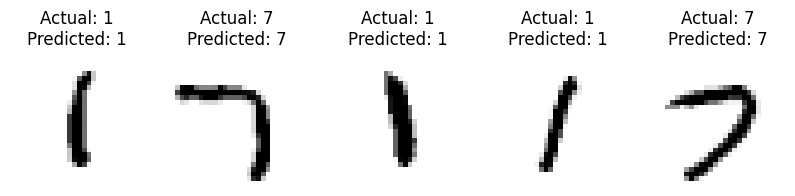

Model: baseline_model_2
1/1 [==============================] - 0s 25ms/step


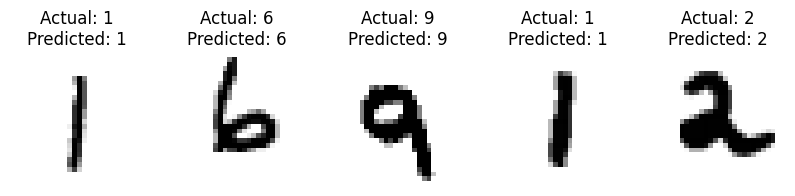

Model: baseline_model_3
1/1 [==============================] - 0s 25ms/step


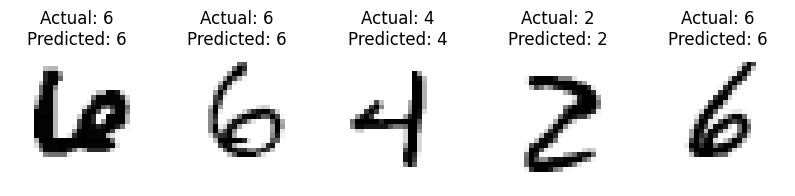

Model: tanh_activation_model_1
1/1 [==============================] - 0s 27ms/step


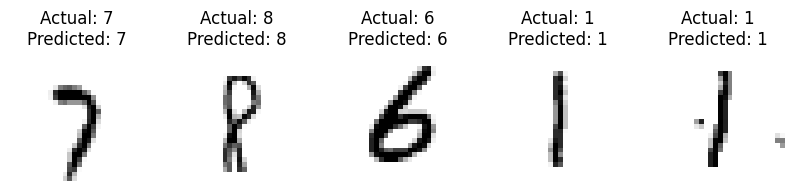

Model: tanh_activation_model_2
1/1 [==============================] - 0s 28ms/step


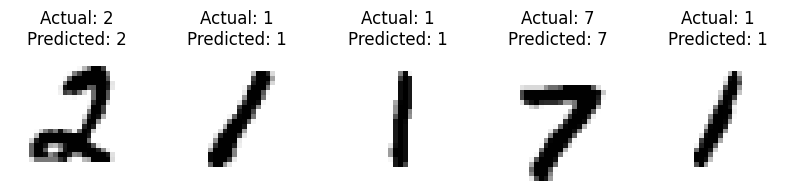

Model: tanh_activation_model_3
1/1 [==============================] - 0s 31ms/step


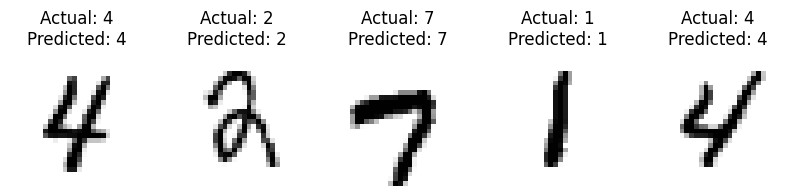

Model: attention_mechanism_model_1
1/1 [==============================] - 0s 25ms/step


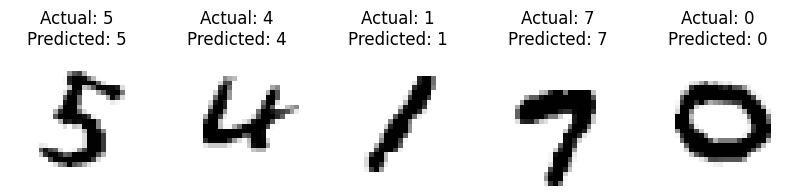

Model: attention_mechanism_model_2
1/1 [==============================] - 0s 22ms/step


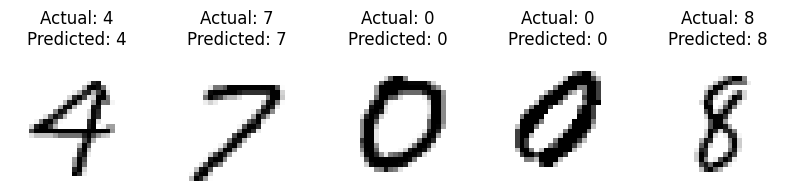

Model: attention_mechanism_model_3
1/1 [==============================] - 0s 24ms/step


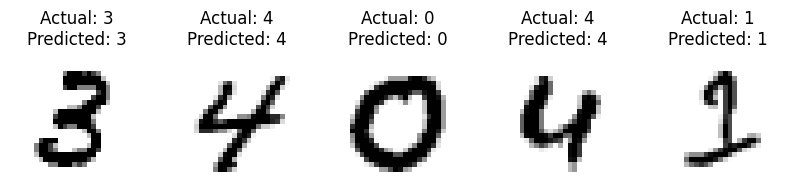

In [28]:
# Define the number of examples to choose
num_examples = 5

# Iterate through each loaded model
for model_name, loaded_model in loaded_models.items():
    print(f"Model: {model_name}")
    
    # Choose random indices from the validation set
    random_indices = np.random.choice(val_img.shape[0], num_examples)
    
    # Predict labels for the chosen examples
    predicted_labels = loaded_model.predict(val_img[random_indices])
    predicted_classes = np.argmax(predicted_labels, axis=1)
    
    # Plot the examples
    plt.figure(figsize=(10, 5))
    for i, idx in enumerate(random_indices):
        plt.subplot(1, num_examples, i + 1)
        plt.imshow(val_img[idx].reshape(28, 28), cmap=plt.cm.binary)
        plt.title(f"Actual: {np.argmax(val_label[idx])}\nPredicted: {predicted_classes[i]}")
        plt.axis('off')
    plt.show()


In [30]:
# Create dictionaries to store predicted and true classes for all models
predicted_classes_all = {}
true_classes_all = {}

# Iterate through each loaded model
for model_name, loaded_model in loaded_models.items():
    print(f"Model: {model_name}")
    
    # Predict labels for all examples in the validation set
    predicted_labels_all = loaded_model.predict(val_img)
    predicted_classes = np.argmax(predicted_labels_all, axis=1)
    predicted_classes_all[model_name] = predicted_classes
    
    # Convert one-hot encoded labels back to integers
    true_classes = np.argmax(val_label, axis=1)
    true_classes_all[model_name] = true_classes


Model: baseline_model_1
313/313 [==============================] - 1s 4ms/step
Model: baseline_model_2
313/313 [==============================] - 1s 4ms/step
Model: baseline_model_3
313/313 [==============================] - 1s 4ms/step
Model: tanh_activation_model_1
313/313 [==============================] - 1s 4ms/step
Model: tanh_activation_model_2
313/313 [==============================] - 1s 4ms/step
Model: tanh_activation_model_3
313/313 [==============================] - 1s 4ms/step
Model: attention_mechanism_model_1
313/313 [==============================] - 1s 4ms/step
Model: attention_mechanism_model_2
313/313 [==============================] - 1s 4ms/step
Model: attention_mechanism_model_3
313/313 [==============================] - 1s 4ms/step


Model: baseline_model_1


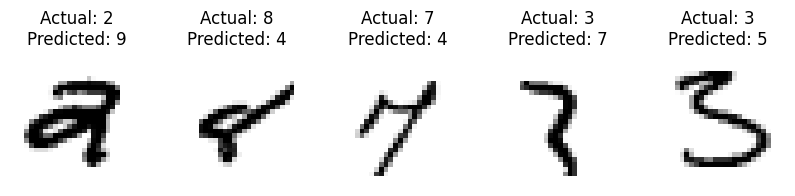

Model: baseline_model_2


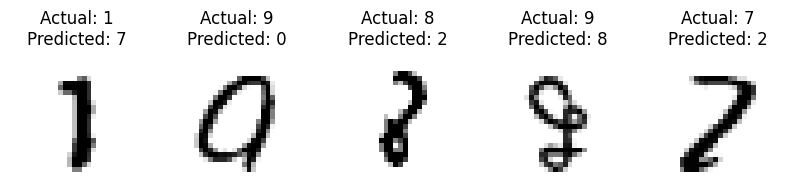

Model: baseline_model_3


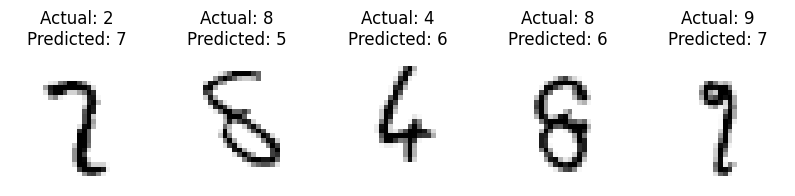

Model: tanh_activation_model_1


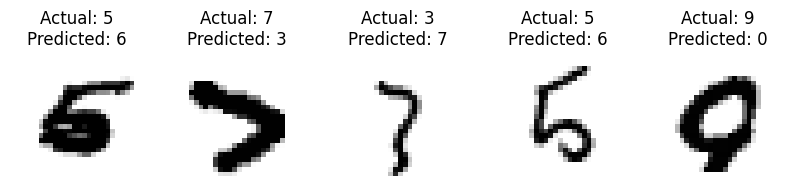

Model: tanh_activation_model_2


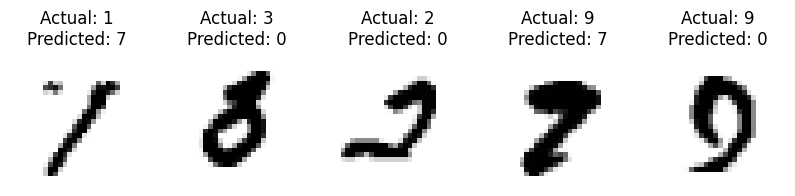

Model: tanh_activation_model_3


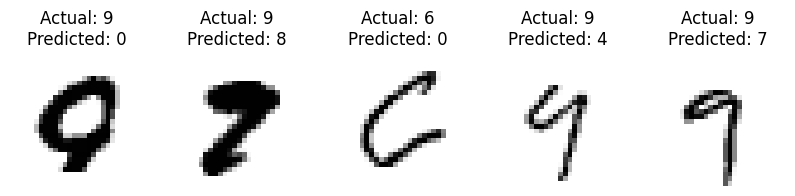

Model: attention_mechanism_model_1


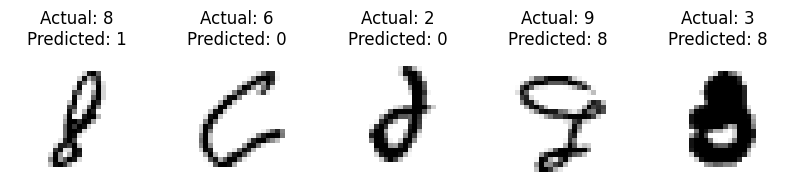

Model: attention_mechanism_model_2


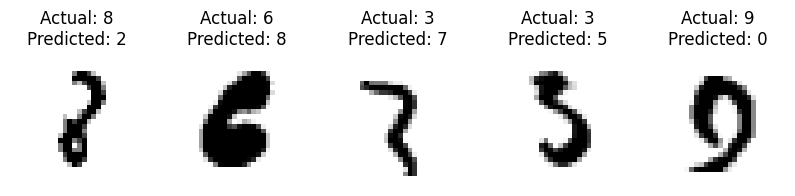

Model: attention_mechanism_model_3


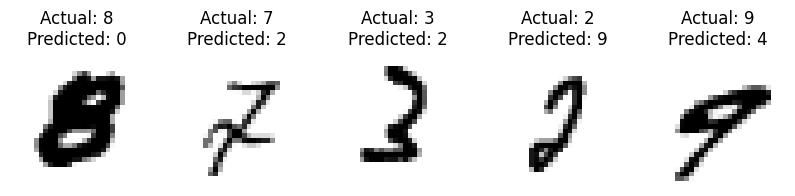

In [32]:
# Iterate through each loaded model
for model_name in loaded_models.keys():
    print(f"Model: {model_name}")
    
    # Find indices of incorrectly classified examples
    incorrect_indices = np.where(predicted_classes_all[model_name] != true_classes_all[model_name])[0]

    # Choose random incorrect indices
    num_incorrect_examples = 5
    random_incorrect_indices = np.random.choice(incorrect_indices, min(num_incorrect_examples, len(incorrect_indices)), replace=False)

    # Plot incorrect examples
    plt.figure(figsize=(10, 5))
    for i, idx in enumerate(random_incorrect_indices):
        plt.subplot(1, min(num_incorrect_examples, len(incorrect_indices)), i + 1)
        plt.imshow(val_img[idx].reshape(28, 28), cmap=plt.cm.binary)
        plt.title(f"Actual: {true_classes_all[model_name][idx]}\nPredicted: {predicted_classes_all[model_name][idx]}")
        plt.axis('off')
    plt.show()


Model: baseline_model_1


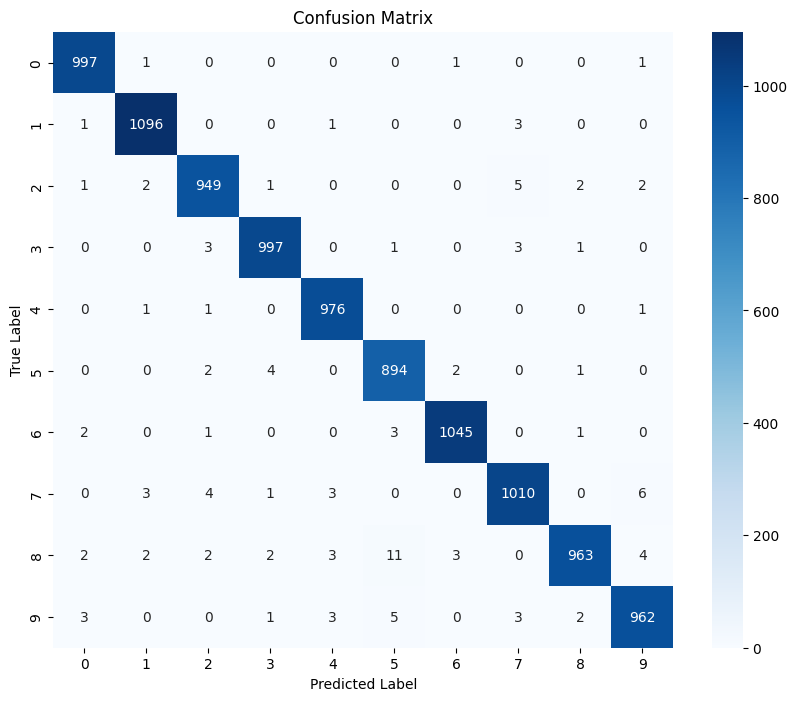

Model: baseline_model_2


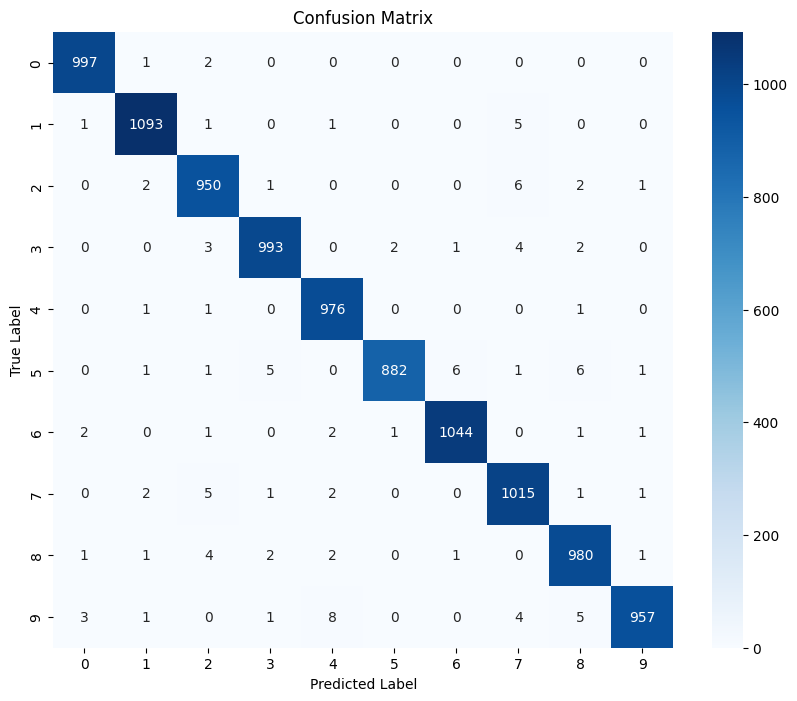

Model: baseline_model_3


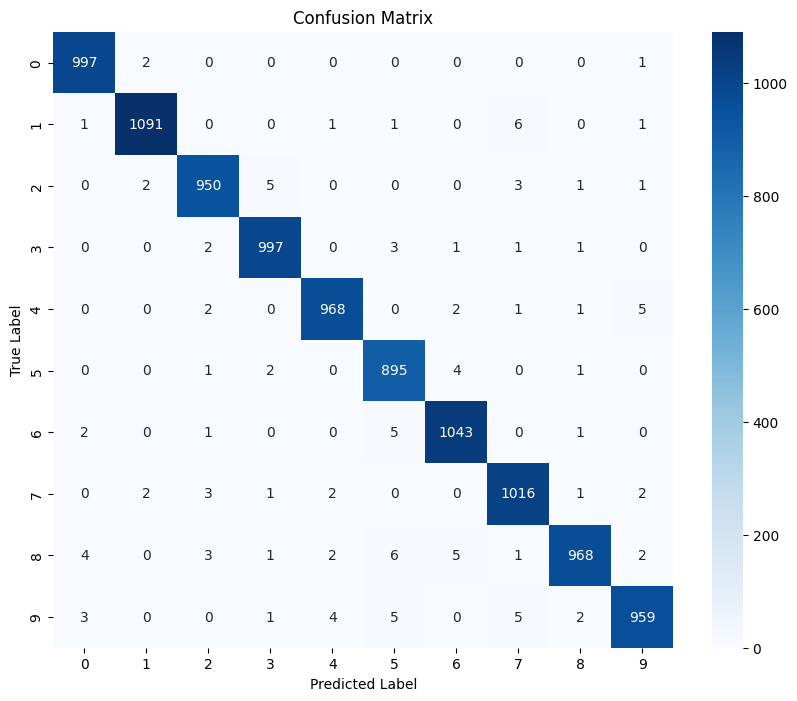

Model: tanh_activation_model_1


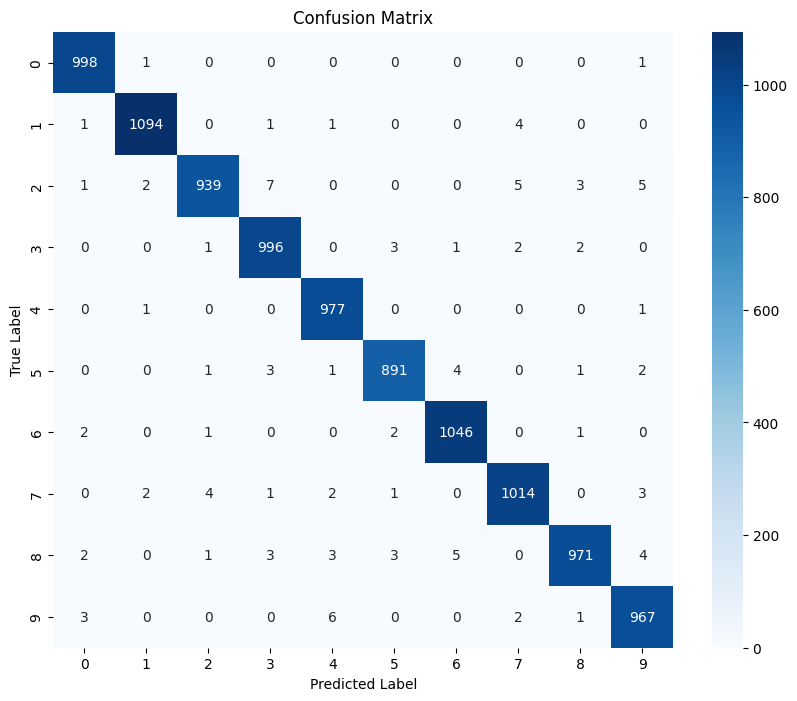

Model: tanh_activation_model_2


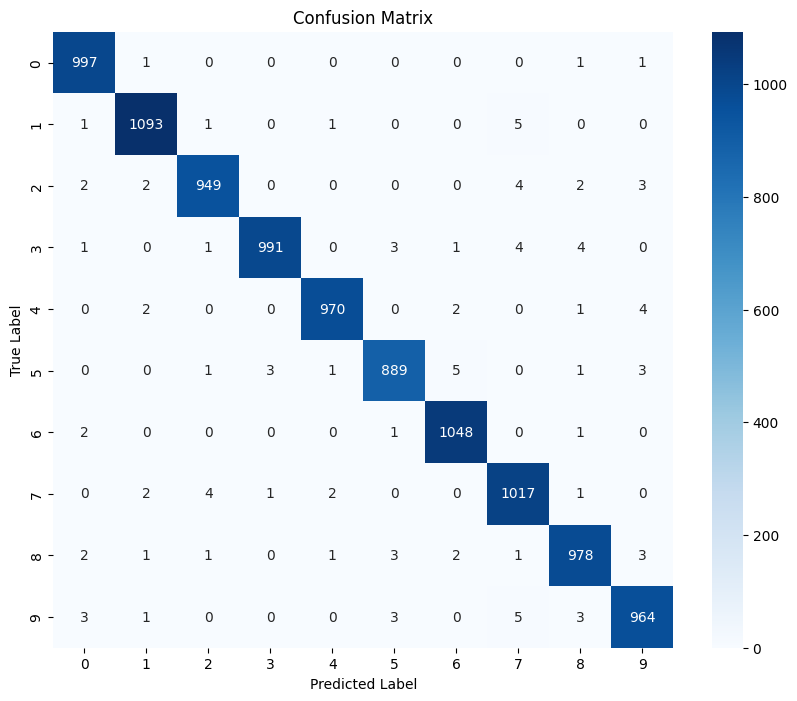

Model: tanh_activation_model_3


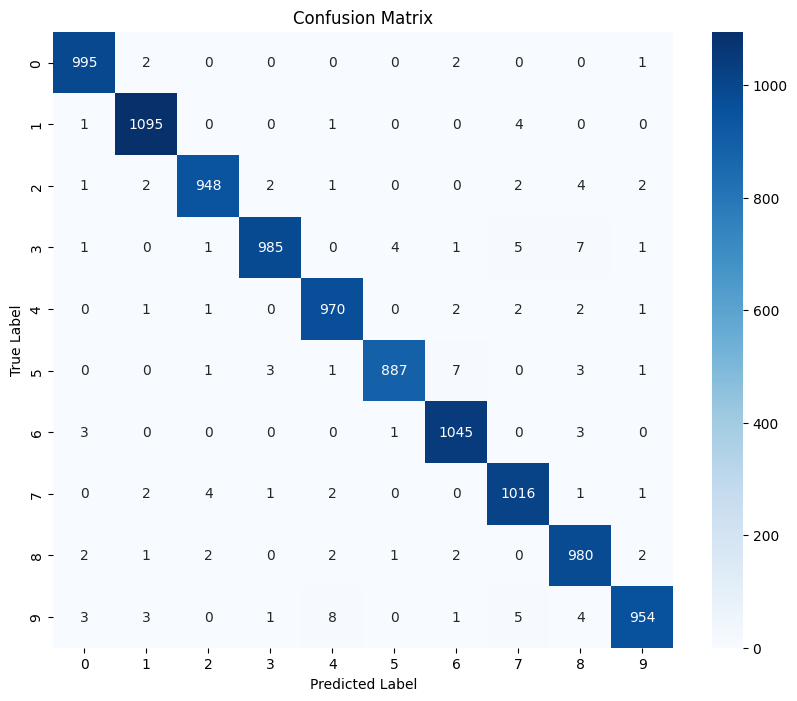

Model: attention_mechanism_model_1


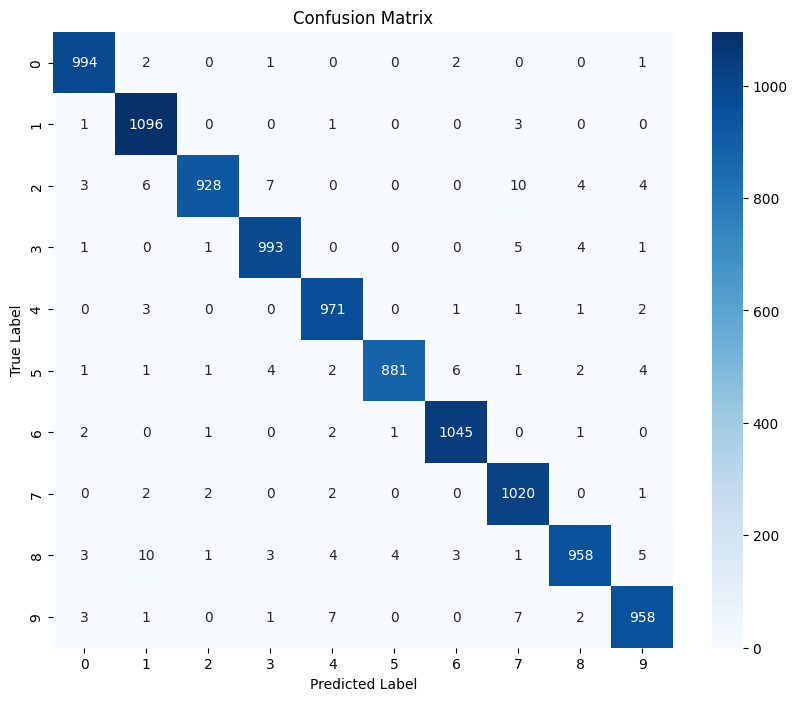

Model: attention_mechanism_model_2


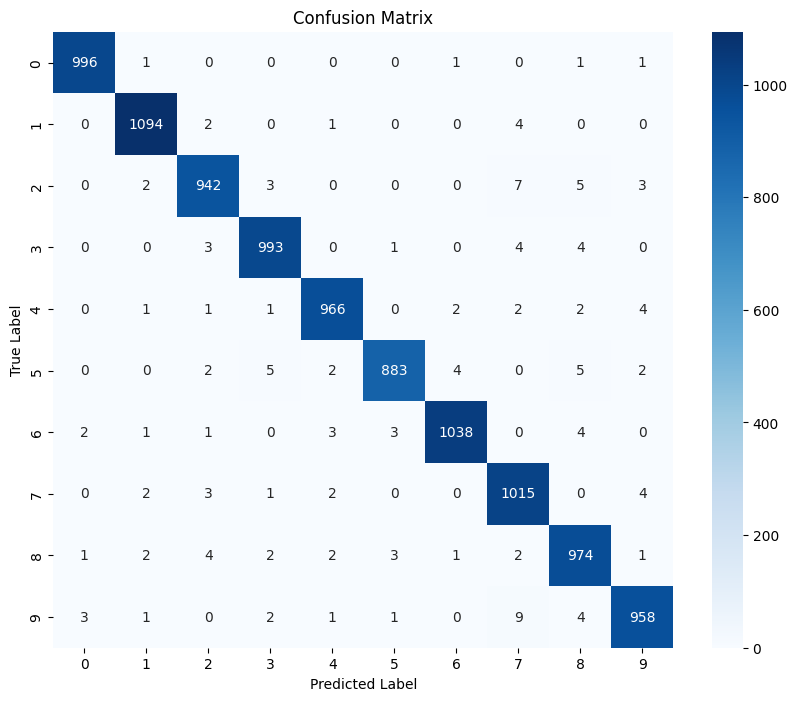

Model: attention_mechanism_model_3


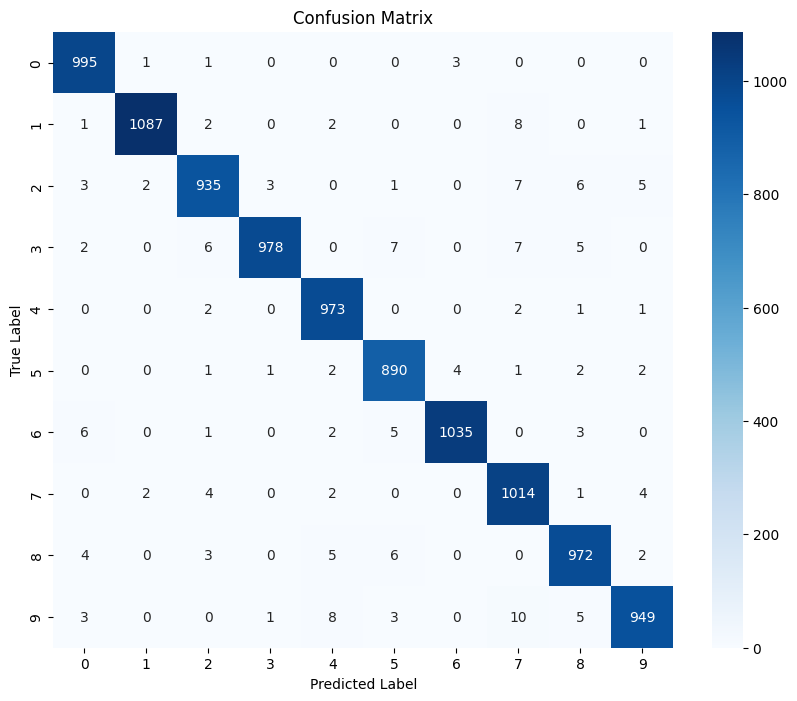

In [33]:
# Iterate through each loaded model to create and plot confusion matrices
for model_name in loaded_models.keys():
    print(f"Model: {model_name}")
    
    # Create confusion matrix
    conf_matrix = confusion_matrix(true_classes_all[model_name], predicted_classes_all[model_name])

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


In [34]:
def most_confused_numbers(conf_matrix):
    """
    Find the most confused numbers based on the confusion matrix.
    
    Parameters:
        conf_matrix (numpy.ndarray): Confusion matrix.
    
    Returns:
        tuple: Tuple containing the most confused numbers.
    """
    max_confusion = -1
    most_confused = (-1, -1)

    # Iterate over each element of the confusion matrix
    for i in range(len(conf_matrix)):
        for j in range(len(conf_matrix[0])):
            if i != j and conf_matrix[i][j] > max_confusion:
                max_confusion = conf_matrix[i][j]
                most_confused = (i, j)

    return most_confused

# Iterate through each loaded model to find the most confused numbers
for model_name in loaded_models.keys():
    print(f"Model: {model_name}")

    # Create confusion matrix
    conf_matrix = confusion_matrix(true_classes_all[model_name], predicted_classes_all[model_name])

    # Find the most confused numbers
    most_confused = most_confused_numbers(conf_matrix)
    print(f"Most Confused Numbers: {most_confused}")


Model: baseline_model_1
Most Confused Numbers: (8, 5)
Model: baseline_model_2
Most Confused Numbers: (9, 4)
Model: baseline_model_3
Most Confused Numbers: (1, 7)
Model: tanh_activation_model_1
Most Confused Numbers: (2, 3)
Model: tanh_activation_model_2
Most Confused Numbers: (1, 7)
Model: tanh_activation_model_3
Most Confused Numbers: (9, 4)
Model: attention_mechanism_model_1
Most Confused Numbers: (2, 7)
Model: attention_mechanism_model_2
Most Confused Numbers: (9, 7)
Model: attention_mechanism_model_3
Most Confused Numbers: (9, 7)
